In [32]:

import numpy as np
import pickle
import pandas as pd
from Metrics import  Metrics
from math import sqrt
from Configs import  Configs
import torch
import matplotlib.pyplot as plt

In [2]:
data = pickle.load(open('reduced_data_np','rb'))

In [3]:

num_users = np.max(data[:,0])+1
num_books = np.max(data[:,1])+1

R = np.empty((num_users,num_books))
R.fill(np.nan)

for row in data:
    R[row[0]][row[1]] = row[2]

R.shape

(2120, 383)

In [4]:

def make_train_and_val_splits(R, num_rows, num_cols, train_frac):
    z_full = np.empty((num_rows, num_cols))
    R_train, R_val = z_full, z_full
    R_train.fill(np.nan)
    R_val.fill(np.nan)
    did_train, did_val = False, False
    for row in range(num_rows):
        for col in range(num_cols):
            if np.random.random() < train_frac:
                R_train[row, col] = R[row, col]
                did_train = True
            else:
                R_val[row, col] = R[row, col]
                did_val = True
    assert did_train and did_val
    return R_train, R_val


In [5]:
R_train, R_val = make_train_and_val_splits(R,num_users,num_books,train_frac=.75)

In [6]:
class MatrixFactorizationLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.is_linear = True
    
    def forward(self):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        raise NotImplementedError()
    
    def optimize(self, loss, R, R_hat, N):
        raise NotImplementedError()
    
    @staticmethod
    def mask_out_nans(R, R_hat):
        lib = np if isinstance(R, np.ndarray) else torch
        R_mask = lib.isnan(R)
        R[R_mask] = R_hat[R_mask]
        N = (R.shape[0] * R.shape[1]) - R_mask.sum()
        return R, N


In [7]:
class MatrixFactorizationCustomLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_books, K, lr):
        super().__init__()
        self.lr = lr
        self.U = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_users, K))
        self.V = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_books, K))
    
    @staticmethod
    def xavier_uniform_array(arr_shape):
        limit = sqrt(6. / sqrt(arr_shape[0] + arr_shape[1]))
        weights = np.random.uniform(-limit, limit, size=arr_shape)
        return weights
    
    def forward(self):
        return self.U @ self.V.T
        
    @staticmethod
    def _calc_mse(R, R_hat, N):
        return np.square(R - R_hat).sum() / N
    
    def calculate_loss(self, R, R_hat):
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        # MSE and masked R
        loss = MatrixFactorizationCustomLinearModel._calc_mse(R, R_hat, N)
        return loss, loss, R, N
    
    @staticmethod
    def _calc_mse_gradient(R, R_hat, M, N):
        return (R - R_hat)@M * -2. / N
    
    def optimize(self, loss, R, R_hat, N):
        # Calc gradient of MSE for each factor matrix ie parameter
        # MSE grad
        U_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R, R_hat, self.V, N)
        V_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R.T, R_hat.T, self.U, N)
        # Update U and V based on gradient and step size
        self.U -= self.lr * U_grad
        self.V -= self.lr * V_grad

In [58]:
def train_linear_model(MF_model, R_train, R_val, num_epochs):
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        # Reconstruct R_hat from latent factor matrices
        R_hat = MF_model.forward()
        # Calc MSE loss of this reconstruction
        # And create a nan masked R_train for future use
        train_loss, np_train_loss, R_train_masked, N = MF_model.calculate_loss(R_train.copy(), R_hat)
        # Calc grad and update
        MF_model.optimize(train_loss, R_train_masked, R_hat, N)
        train_losses.append(np_train_loss)
        
        # Eval
        val_loss, np_val_loss, _, _ = MF_model.calculate_loss(R_val.copy(), R_hat)
        val_losses.append(np_val_loss)
        #print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return R_hat,train_losses,val_losses


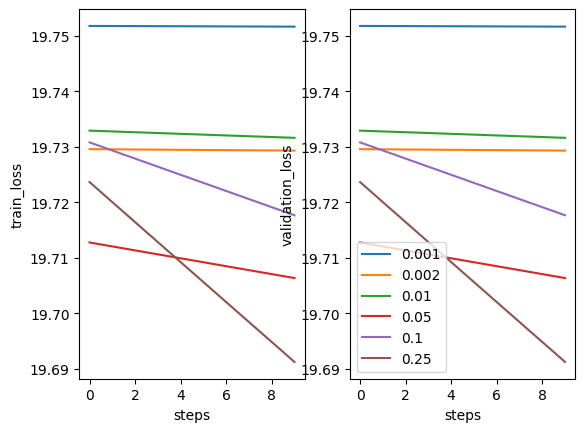

In [69]:
# Convergence rates:

lr = [0.001,0.002,0.01,0.05,0.1,0.25]



for i in lr:
    model = MatrixFactorizationCustomLinearModel(num_users,num_books,K=64,lr=i)
    R_hat,t_l,val_l = train_linear_model(model, R_train, R_val, num_epochs=10)
    plt.subplot(1, 2, 1)
    plt.xlabel('steps')
    plt.ylabel('train_loss')
    plt.plot(np.arange(10),t_l)
    plt.subplot(1, 2, 2)
    plt.xlabel('steps')
    plt.ylabel('validation_loss')    
    plt.plot(np.arange(10),val_l)
plt.legend(lr)
plt.show()


In [10]:
val_pred_true_list = []

import math

for u in range(num_users):
    for  v in range(num_books):
        if not math.isnan(R_val[u][v]):   
            val_pred_true_list.append((u,v,R_val[u][v],R_hat[u][v]))
                        
np_arr = np.asarray(val_pred_true_list,dtype=int)

In [25]:

hr_10, ndcg_10 =0.0,0.0
l=0

for i in range(num_users):
    l +=1
    y_score= np_arr[np.where(np_arr[:,0]==i)][:,3]
    y_true = np_arr[np.where(np_arr[:,0]==i)][:,2]

    df = pd.DataFrame({'True':y_true})
    df['pred']=y_score

    configs = {'top_k': 10, 'num_negative_test': 49, }
    metric = Metrics(configs)
    hr = metric.get_hit_ratio(df)
    ndcg = metric.get_ndcg(df)
    hr_10 += hr[10]
    ndcg_10 += ndcg[10]
    

hr_10 /= l
ndcg_10 /= l

In [26]:
hr_10,ndcg_10

(0.9797169811320755, 0.8423928922751897)